In [1]:
import numpy as np
import pandas as pd
import volpriceinference as vl
import matplotlib as mpl
import seaborn as sns
import logging
import sys
from scipy import special

In [2]:
%matplotlib inline
mpl.style.use('seaborn-talk')
np.set_printoptions(precision=3)

In [3]:
logging.captureWarnings(True)
root_logger = logging.getLogger()
root_logger.setLevel(logging.INFO)
info_handler = logging.FileHandler('../logging.tmp.txt')
info_handler.addFilter(lambda record: record.levelno <= logging.WARNING)
error_handler = logging.StreamHandler(sys.stderr)
error_handler.addFilter(lambda record: record.levelno > logging.WARNING)
root_logger.addHandler(info_handler)
root_logger.addHandler(error_handler)

In [41]:
bounds = {'pi': {'max': 0, 'min':-32, 'dim':32}, 'phi': {'max': -.18, 'min':-.39, 'dim':4}, 
          'theta': {'max':1.25, 'min': 0, 'dim':10}}
innov_dim = 2000

In [42]:
vl.__version__

'0.0.28-py37_0'

## Load the data

In [43]:
with pd.HDFStore('../data/spy_daily_estimates_2003-2017_1000_1sec.hdf') as store:
    daily_rtn = store['daily_rtn'] * 25.2 
    vol = store['discrete_vol_est'] * 25.2**2
    data = pd.concat([daily_rtn, vol.diffusion + vol.jumps], axis=1).dropna()
    data.columns = ['rtn', 'vol'] 

In [44]:
data.head()

,rtn,vol
2003-01-02,0.641961,0.087998
2003-01-03,0.053996,0.077860
2003-01-06,0.515051,0.045863
2003-01-07,-0.089675,0.082945
2003-01-08,-0.274812,0.064468


In [45]:
data.transform(lambda x: np.sqrt(x) if x.name == 'vol' else x).cov()

,rtn,vol
rtn,0.055233,-0.002298
vol,-0.002298,0.018866


In [46]:
data.corr()

,rtn,vol
rtn,1.000000,-0.024379
vol,-0.024379,1.000000


In [47]:
data.describe()

,rtn,vol
count,3713.000000,3713.000000
mean,0.002342,0.056213
std,0.235017,0.144584
min,-2.078183,0.001233
25%,-0.095404,0.013806
50%,0.012830,0.024160
75%,0.109952,0.050309
max,1.803101,4.218808


In [48]:
data.describe()

,rtn,vol
count,3713.000000,3713.000000
mean,0.002342,0.056213
std,0.235017,0.144584
min,-2.078183,0.001233
25%,-0.095404,0.013806
50%,0.012830,0.024160
75%,0.109952,0.050309
max,1.803101,4.218808


In [49]:
data_for_plot = data.copy()
data_for_plot.vol *= 100
data_for_plot.rtn *= 10

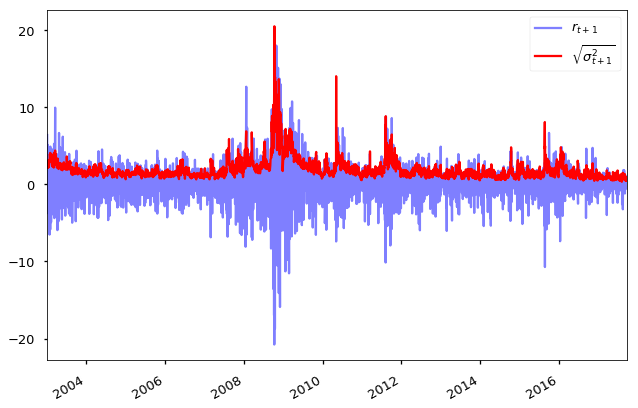

In [50]:
fig1, ax1 = mpl.pyplot.subplots()
data_for_plot['rtn'].plot(ax=ax1, color='blue', alpha=.5, label="$r_{t+1}$")
data_for_plot['vol'].apply(np.sqrt).plot(ax=ax1, label='$\sqrt{\sigma^2_{t+1}}$', color='red')
ax1.legend()
fig1.savefig('../doc/figures/time_series.tmp.pdf', frameon=False, pad_inches=0, bbox_inches='tight',
            transparent=True)

(None,)

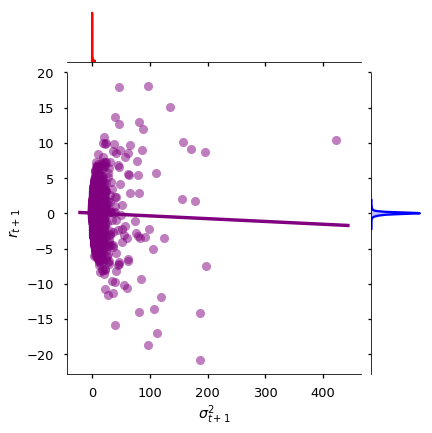

In [51]:
joint_grid = sns.JointGrid(x='vol', y='rtn', data=data_for_plot) #, xlim=[-.1, 3], ylim=[-2, 2])
joint_grid.plot_joint(sns.regplot, ci=None, color='purple', scatter_kws={"alpha":.5})
sns.kdeplot(data['vol'], ax=joint_grid.ax_marg_x, legend=None, shade=True, color='red')
sns.kdeplot(data['rtn'], ax=joint_grid.ax_marg_y, legend=None, shade=True, color='blue', vertical=True)
joint_grid.set_axis_labels("$\sigma^2_{t+1}$","$r_{t+1}$")
joint_grid.savefig('../doc/figures/joint_dist.tmp.pdf', frameon=False, pad_inches=0, bbox_inches='tight',
            transparent=True),

In [52]:
data_for_plot.describe()

,rtn,vol
count,3713.000000,3713.000000
mean,0.023421,5.621287
std,2.350165,14.458447
min,-20.781833,0.123335
25%,-0.954041,1.380618
50%,0.128299,2.416002
75%,1.099523,5.030940
max,18.031014,421.880784


In [53]:
stats.kurtosis(data_for_plot, fisher=False)

array([ 13.066, 243.401])

In [54]:
stats.skew(data_for_plot)

array([-0.312, 12.209])

In [55]:
data_for_plot.corr()

,rtn,vol
rtn,1.000000,-0.024379
vol,-0.024379,1.000000


## We now estimate the volatility paramters.

In [56]:
omega, omega_cov = vl.estimate_params_strong_id(data, bounds=bounds)

In [57]:
omega

{'gamma': 0.025965685942692017,
 'beta': 1.1135527707674138,
 'psi': -1.5373902507632273,
 'zeta': 0.9086856628806304,
 'log_both': -4.452601183471653,
 'log_scale': -3.484493100458501,
 'logit_rho': 1.2143874995349415,
 'phi': -0.30065788058164783,
 'pi': -22.779895300930832,
 'theta': 0.2793226970893515}

In [58]:
estimates, covariance = vl.estimate_params(data, *vl.compute_vol_gmm(data.vol))

In [59]:
estimates

{'gamma': 0.025965685942692017,
 'beta': 1.1135527707674138,
 'psi': -1.5373902507632273,
 'zeta': 0.9086856628806304,
 'log_both': -4.452601183471653,
 'log_scale': -3.484493100458501,
 'logit_rho': 1.2143874995349415}

## I compute the point estimates and confidence intervals for the volatility parameters.

### c

In [60]:
(100 * np.exp(estimates['log_scale']),
100 * np.exp(estimates['log_scale'] - 1.96 * covariance.loc['log_scale', 'log_scale']**.5),
 100 * np.exp(estimates['log_scale'] + 1.96 * covariance.loc['log_scale', 'log_scale']**.5))


(3.0669300744161987, 1.3843178480956426, 6.79472571584491)

### delta

In [61]:
log_mean = estimates['log_both'] - estimates['log_scale']
log_var = (covariance.loc['log_scale', 'log_scale'] + covariance.loc['log_both', 'log_both'] 
           - 2 * covariance.loc['log_scale', 'log_both'])
(100 * np.exp(log_mean),
 100 * np.exp(log_mean - 1.96 * log_var**.5),
 100 * np.exp(log_mean + 1.96 * log_var**.5)
)

(37.98009106060775, 17.652827343850205, 81.71423698168003)

### rho

In [62]:
mean = estimates['logit_rho']
std = covariance.loc['logit_rho', 'logit_rho']**.5
(special.expit(mean), special.expit(mean - 1.96 * std), special.expit(mean + 1.96*std))

(0.7710743457220686, 0.6747187511483863, 0.8454262029364638)

In [63]:
covariance

,beta,gamma,log_both,log_scale,logit_rho,psi,zeta
beta,0.009748,-0.000035,0.000000,0.000000,0.000000,-0.009132,0.000000
gamma,-0.000035,0.000006,0.000000,0.000000,0.000000,-0.000080,0.000000
log_both,0.000000,0.000000,0.020524,0.016218,-0.031927,0.000000,0.000000
log_scale,0.000000,0.000000,0.016218,0.164716,0.005152,0.000000,0.000000
logit_rho,0.000000,0.000000,-0.031927,0.005152,0.061176,0.000000,0.000000
psi,-0.009132,-0.000080,0.000000,0.000000,0.000000,0.014926,0.000000
zeta,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000431


In [64]:
data.vol.sort_values(ascending=True).head()

2017-08-07    0.001233
2017-09-14    0.002147
2017-09-22    0.002169
2016-11-25    0.002262
2017-07-24    0.002427
Name: vol, dtype: float64

In [65]:
omega2, omega_cov2 = vl.estimate_params(data)

In [66]:
qlr_stats = vl.compute_qlr_stats(omega=omega2, omega_cov=omega_cov2, bounds=bounds,use_tqdm=True)

In [ ]:
qlr_draws = vl.compu++te_qlr_sim(omega=omega2, omega_cov=omega_cov2, bounds=bounds, use_tqdm=True,
                               alpha=0.05, innov_dim=innov_dim)

In [ ]:
qlr_draws.to_json(f'../results/qlr_draws_on_data_{innov_dim}.tmp.json')

In [ ]:
qlr_draws = pd.read_json(f'../results/qlr_draws_on_data_{innov_dim}.tmp.json')

In [ ]:
np.sort(qlr_draws.phi.unique()) - np.sort(qlr_stats.phi.unique())

In [ ]:
merged_values = vl.merge_draws_and_sims(qlr_stats=qlr_stats, qlr_draws=qlr_draws)

In [ ]:
merged_values.head()

In [ ]:
accepted_vals = merged_values.query('qlr_stats < qlr_draws')

In [ ]:
accepted_vals.head()

In [ ]:
def constraint(scale, psi, zeta, equity_price):
    
    vol_price  = -1 / scale - ((psi * (equity_price-1) + zeta/2 * (equity_price-1)**2))
    
    return  vol_price

In [ ]:
ar_accepted_vals.max()

In [ ]:
ar_accepted_vals.min()

In [ ]:
qlr_stats.head()

In [ ]:
ar_accepted_vals.max()

In [ ]:
accepted_vals.max()

In [ ]:
innov_dim

In [ ]:
omega

In [ ]:
stats.chi2.ppf(df=4, q=.95)

In [ ]:
accepted_vals.head()

In [ ]:
bounds

In [ ]:
fig3, ax3 = mpl.pyplot.subplots()
pi_patch_width = 1.2 * (bounds['pi']['max'] - bounds['pi']['min']) / bounds['pi']['dim']
theta_patch_height = 1.2 * (bounds['theta']['max'] - bounds['theta']['min']) / bounds['theta']['dim']
   
for row in accepted_vals.itertuples(index=False):
    patch = mpl.patches.Rectangle((row.pi, row.theta), width=pi_patch_width, height=theta_patch_height,
                                  fill=True, color='purple')
    ax3.add_patch(patch)
    
max_y = bounds['theta']['max']
min_x = bounds['pi']['min']

ax3.axvline(0,  ymin=0, ymax=1, color='black')
ax3.axhline(0,  xmin=1, xmax=0, color='black')

white_rect1 = mpl.patches.Rectangle((0,-1), 2, max_y + 2, angle=0.0, color='white', fill=True)
white_rect2 = mpl.patches.Rectangle((min_x-1,-1), abs(min_x) + 2, 1, angle=0.0, color='white', fill=True)
ax3.add_patch(white_rect1)
ax3.add_patch(white_rect2)
ax3.set_ylim([-.2, 10])
ax3.set_xlim([-35, .2])
ax3.set_ylabel(r'$\kappa$')
ax3.set_xlabel(r'$\pi$')
# ax3.legend(handles=[patch], labels=['QLR Confidence Interval'],
#            loc='upper left')

fig3.savefig(f'../doc/figures/qlr_confidence_region_{innov_dim}.tmp.pdf', frameon=False, pad_inches=0, 
             bbox_inches='tight', transparent=True)

In [ ]:
fig4, ax4 = mpl.pyplot.subplots()
eigvals, eigvectors = np.linalg.eig(omega_cov.loc[['pi', 'theta'], ['pi', 'theta']])
root_eigvals = np.sqrt(eigvals)

corr = omega_cov.loc['theta', 'pi'] / np.sqrt(omega_cov.loc['theta', 'theta'] * omega_cov.loc['pi', 'pi'])
standard_patch = mpl.patches.Ellipse(xy=(omega['pi'], omega['theta']), 
                                     width=1.96 * 2 * root_eigvals[0], 
                                     height=1.96 * 2 * root_eigvals[1], 
                                     angle=np.rad2deg(np.arccos(eigvectors[0,0])), color='purple')
ax4.add_patch(standard_patch)
   
max_y = bounds['theta']['max']
min_x = bounds['pi']['min']

ax4.axvline(0,  ymin=0, ymax=1, color='black')
ax4.axhline(0,  xmin=1, xmax=0, color='black')

white_rect1 = mpl.patches.Rectangle((0,-1), 2, max_y + 2, angle=0.0, color='white', fill=True)
white_rect2 = mpl.patches.Rectangle((-35,-1), abs(min_x) + 2, 1, angle=0.0, color='white', fill=True)
ax4.add_patch(white_rect1)
ax4.add_patch(white_rect2)
ax4.set_ylim([-.2, 10])
ax4.set_xlim([-35, .2])
ax4.set_ylabel(r'$\kappa$')
ax4.set_xlabel(r'$\pi$')
# ax4.legend(handles=[standard_patch], labels=['Standard Confidence Interval'], loc='upper left')

fig4.savefig(f'../doc/figures/standard_confidence_region.tmp.pdf', frameon=False, pad_inches=0, 
             bbox_inches='tight', transparent=True)

In [ ]:
fig5, ax5 = mpl.pyplot.subplots()

for row in ar_accepted_vals.itertuples(index=False):
    ar_patch = mpl.patches.Rectangle((row.pi, row.theta), width=pi_patch_width, height=theta_patch_height,
                                  fill=True, color='purple', edgecolor='violet')
    ax5.add_patch(ar_patch)
        
max_y = bounds['theta']['max']
min_x = bounds['pi']['min']

ax5.axvline(0,  ymin=0, ymax=1, color='black')
ax5.axhline(0,  xmin=1, xmax=0, color='black')

white_rect1 = mpl.patches.Rectangle((0,-1), 2, max_y + 2, angle=0.0, color='white', fill=True)
white_rect2 = mpl.patches.Rectangle((-35-1,-1), abs(min_x) + 2, 1, angle=0.0, color='white', fill=True)
ax5.add_patch(white_rect1)
ax5.add_patch(white_rect2)
ax5.set_ylim([-.2, 10])
ax5.set_xlim([-35, .2])
ax5.set_ylabel(r'$\kappa$')
ax5.set_xlabel(r'$\pi$')
# ax5.legend(handles=[ar_patch], labels=['AR Confidence Interval'], loc='upper left')

fig5.savefig(f'../doc/figures/ar_confidence_region_{innov_dim}.tmp.pdf', frameon=False, pad_inches=0, 
             bbox_inches='tight', transparent=True)

In [ ]:
qlr_draws_subset = pd.concat([group[group.index == group.idxmax().qlr] 
                              for _, group in qlr_draws.groupby(['pi', 'theta'])])
qlr_draws_pivoted = qlr_draws_subset.drop(
    columns=['phi']).pivot(columns='pi',index='theta', values='qlr').sort_index(by='theta', ascending=False)

In [ ]:
qlr_draws_fig, qlr_draws_ax = mpl.pyplot.subplots()

colormap = mpl.cm.get_cmap('gist_earth')
colormap.set_over('white')
contours = qlr_draws_ax.contourf(qlr_draws_pivoted.columns, qlr_draws_pivoted.index, qlr_draws_pivoted, 
                                 levels=int(qlr_draws.qlr.max()  / 1), cmap=colormap, vmin=0, vmax=10,
                                 extend='neither')
qlr_draws_ax.contour(qlr_draws_pivoted.columns, qlr_draws_pivoted.index, qlr_draws_pivoted, 
                                 levels=int(qlr_draws.qlr.max()  / 1), colors='black',
                    linewidths=1)
qlr_draws_ax.set_xlabel("$\pi$")
qlr_draws_ax.set_ylabel("$\kappa$")

qlr_draws_fig.colorbar(mappable=contours, ax=qlr_draws_ax)
qlr_draws_fig.savefig('../doc/figures/qlr_quantile_contours.tmp.pdf', frameon=False, pad_inches=0,
                      bbox_inches='tight', transparent=True)

In [67]:
qlr_stats_subset = pd.concat([group[group.index == group.idxmin().qlr] 
                              for _, group in qlr_stats.groupby(['pi', 'theta'])])
qlr_stats_subset = qlr_stats_subset.replace(np.inf, 500)
qlr_stats_pivoted = qlr_stats_subset.drop(columns=['phi']).pivot(
    columns='pi',index='theta', values='qlr').sort_index(axis='index').sort_index(by='theta', ascending=False)

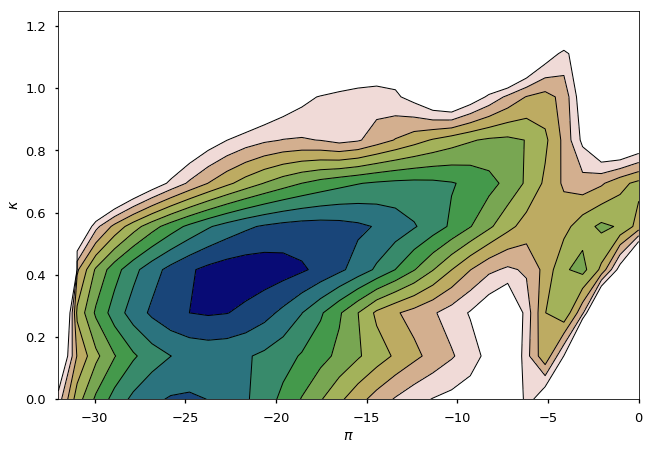

In [68]:
qlr_stats_fig, qlr_stats_ax = mpl.pyplot.subplots()

colormap = mpl.cm.get_cmap('gist_earth')
colormap.set_over('white')
stat_contours = qlr_stats_ax.contourf(qlr_stats_pivoted.columns, qlr_stats_pivoted.index, qlr_stats_pivoted,
                                      levels=int(min(qlr_stats.qlr.max(), 500)), cmap=colormap, vmin=0, 
                                      vmax=10, extend='neither')
qlr_stats_ax.contour(qlr_stats_pivoted.columns, qlr_stats_pivoted.index, qlr_stats_pivoted,
                                      levels=stat_contours.levels[stat_contours.levels <= 10], colors='black',
                    linewidths=1)
qlr_stats_ax.set_xlabel("$\pi$")
qlr_stats_ax.set_ylabel("$\kappa$")

qlr_stats_fig.savefig('../doc/figures/qlr_stats_contours.tmp.pdf', frameon=False, pad_inches=0,
                      bbox_inches='tight', transparent=True)